In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 1900

nband = 1100

nv = 200

dv = 0.005

tsfc =294

ng =7

nref =2

p_refs = (/ 1 , 50 /) 

t_refs = (/ 250 , 250 /) 

ng_refs = (/ 2 , 5 /) 

data wgt
     &     /0.3 , 0.4 , 0.5 , 0.6,
     &     0.7 , 0.85 , 0.9/

option_wgt_flux =2

option_wgt_k =1

option_klin =1

data w_diffuse
     &     /1.55 , 1.55 , 1.55 , 1.55,
     &     1.55 , 1.55 , 1.8/

klin =2e-20

atmosphere_profiles/mls75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

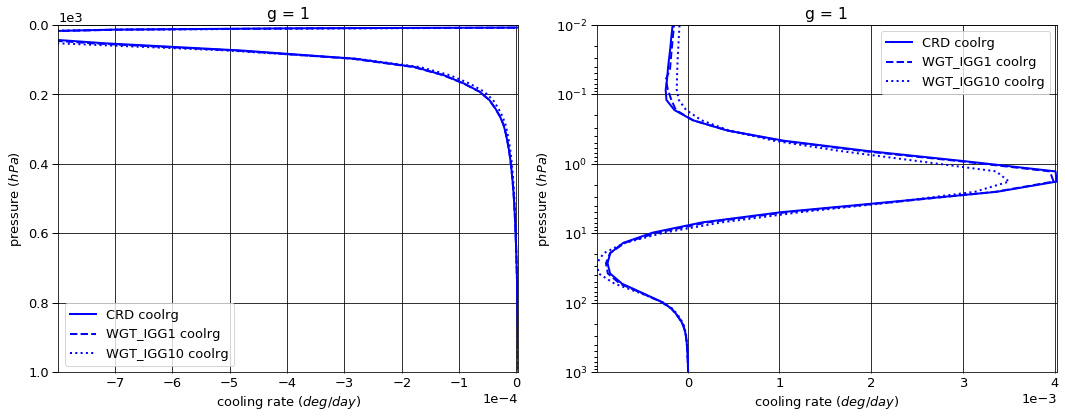

# Figure: cooling rate g-group 2

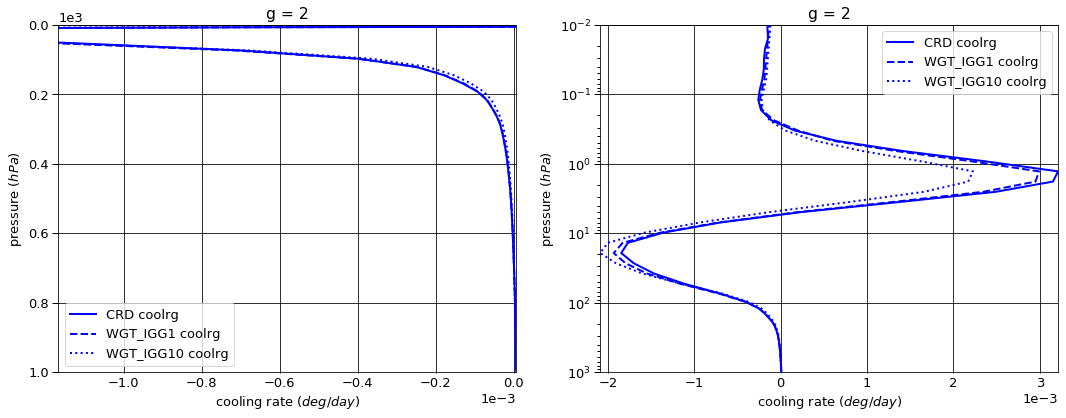

# Figure: cooling rate g-group 3

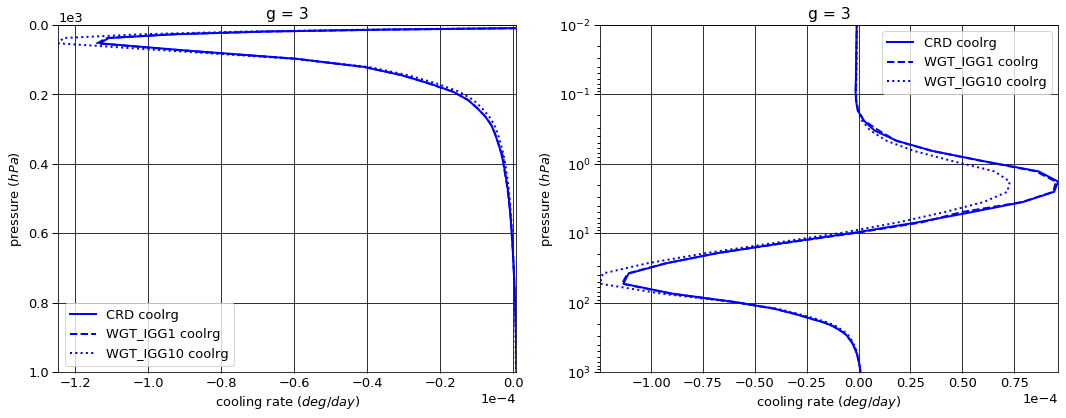

# Figure: cooling rate g-group 4

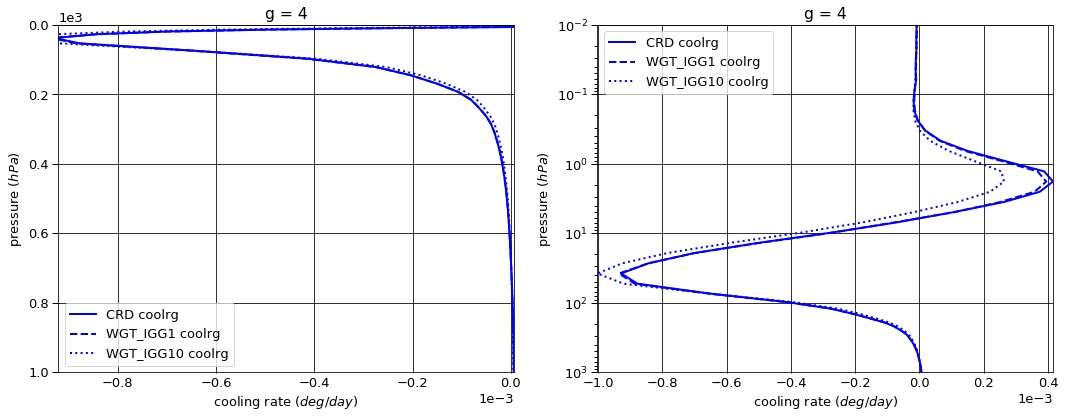

# Figure: cooling rate g-group 5

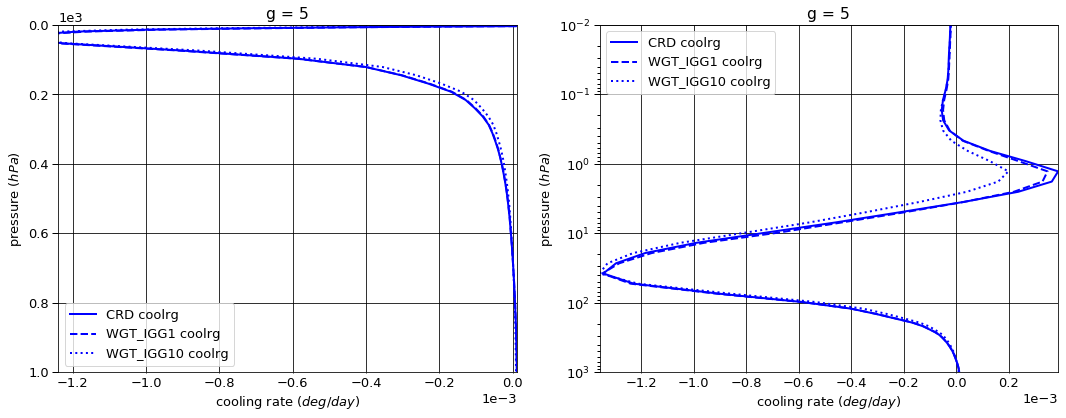

# Figure: cooling rate g-group 6

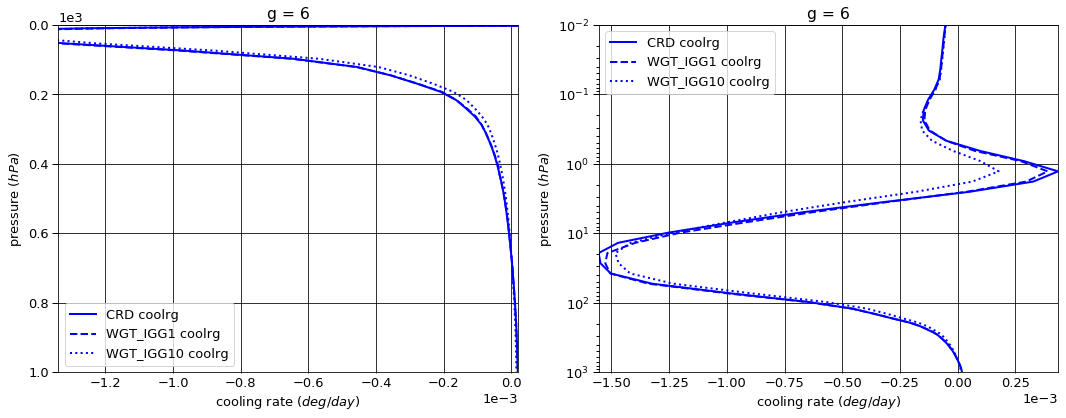

# Figure: cooling rate g-group 7

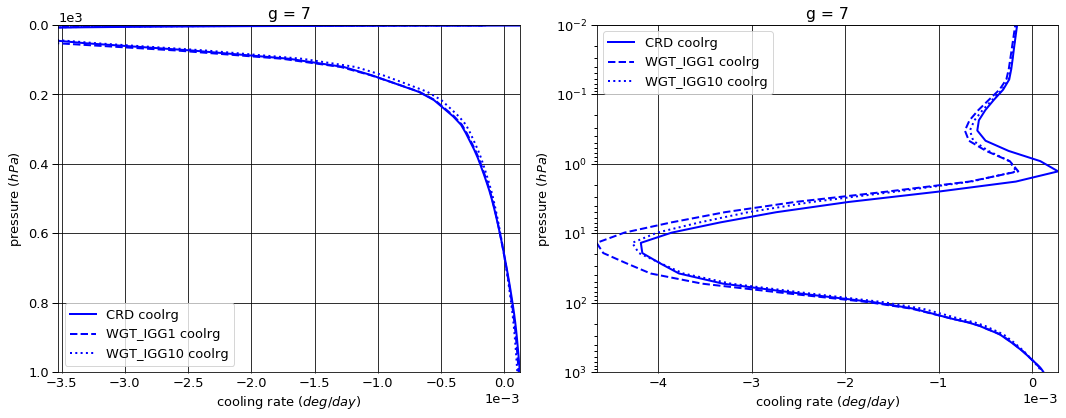

# Figure: cooling rate g-group total

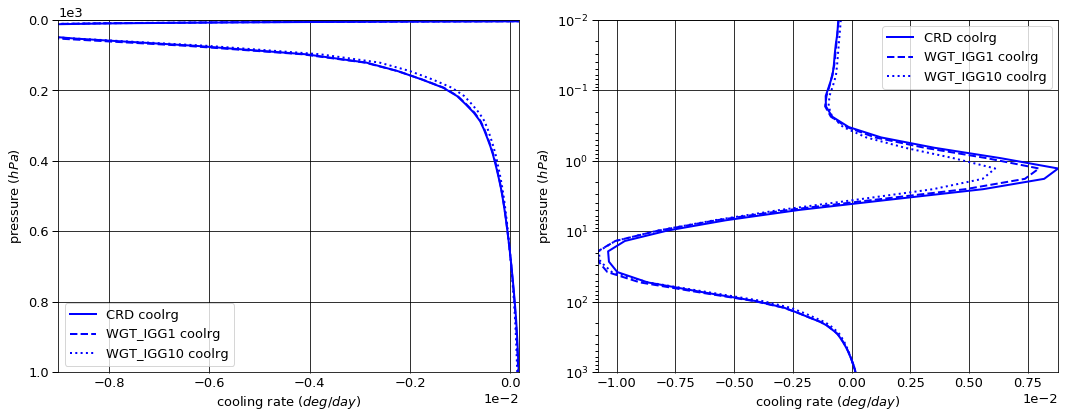

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.002090  0.000000 -0.002090
  1013.0   76    -0.010094  0.000646 -0.009449
2 0.0      1     -0.008766  0.000000 -0.008766
  1013.0   76    -0.024450  0.001390 -0.023060
3 0.0      1     -0.000402  0.000000 -0.000402
  1013.0   76    -0.001942  0.000125 -0.001817
4 0.0      1     -0.006523  0.000000 -0.006523
  1013.0   76    -0.018477  0.000934 -0.017543
5 0.0      1     -0.022640  0.000000 -0.022640
  1013.0   76    -0.041029  0.001610 -0.039419
6 0.0      1     -0.054672  0.000000 -0.054672
  1013.0   76    -0.076984  0.002323 -0.074661
7 0.0      1     -6.386176  0.000000 -6.386176
  1013.0   76    -6.452477  0.010389 -6.442088


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.001976  0.000000 -0.001976
  1013.0   76    -0.010094  0.000643 -0.009451
2 0.0      1     -0.008238  0.000000 -0.008238
  1013.0   76    -0.024450  0.001404 -0.023047
3 0.0      1     -0.000397  0.000000 -0.000397
  1013.0   76    -0.001942  0.000125 -0.001817
4 0.0      1     -0.006484  0.000000 -0.006484
  1013.0   76    -0.018477  0.000932 -0.017545
5 0.0      1     -0.022722  0.000000 -0.022722
  1013.0   76    -0.041029  0.001589 -0.039440
6 0.0      1     -0.054792  0.000000 -0.054792
  1013.0   76    -0.076984  0.002291 -0.074692
7 0.0      1     -6.383567  0.000000 -6.383567
  1013.0   76    -6.452477  0.009880 -6.442597


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.001783  0.000000 -0.001783
  1013.0   76    -0.010094  0.000597 -0.009497
2 0.0      1     -0.008009  0.000000 -0.008009
  1013.0   76    -0.024450  0.001370 -0.023080
3 0.0      1     -0.000363  0.000000 -0.000363
  1013.0   76    -0.001942  0.000114 -0.001827
4 0.0      1     -0.006486  0.000000 -0.006486
  1013.0   76    -0.018477  0.000857 -0.017620
5 0.0      1     -0.023613  0.000000 -0.023613
  1013.0   76    -0.041029  0.001411 -0.039618
6 0.0      1     -0.056901  0.000000 -0.056901
  1013.0   76    -0.076984  0.001969 -0.075015
7 0.0      1     -6.389665  0.000000 -6.389665
  1013.0   76    -6.452477  0.008976 -6.443500


WGT_IGG1 - CRD


flug          fldg         fnetg
g pressure level                                          
1 0.0      1      1.133516e-04  0.000000e+00  1.133516e-04
  1013.0   76    -1.734723e-18 -2.863880e-06 -2.863900e-06
2 0.0      1      5.284507e-04  0.000000e+00  5.284507e-04
  1013.0   76     0.000000e+00  1.371610e-05  1.371600e-05
3 0.0      1      4.784830e-06  0.000000e+00  4.784830e-06
  1013.0   76     0.000000e+00 -8.616000e-08 -8.620000e-08
4 0.0      1      3.878480e-05  0.000000e+00  3.878480e-05
  1013.0   76     0.000000e+00 -2.038480e-06 -2.038000e-06
5 0.0      1     -8.199900e-05  0.000000e+00 -8.199900e-05
  1013.0   76     0.000000e+00 -2.097590e-05 -2.097600e-05
6 0.0      1     -1.208140e-04  0.000000e+00 -1.208140e-04
  1013.0   76     0.000000e+00 -3.156780e-05 -3.156700e-05
7 0.0      1      2.608900e-03  0.000000e+00  2.608900e-03
  1013.0   76     0.000000e+00 -5.095297e-04 -5.095000e-04


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      3.069353e-04  0.000000  0.000307
  1013.0   76    -1.734723e-18 -0.000049 -0.000049
2 0.0      1      7.568279e-04  0.000000  0.000757
  1013.0   76     0.000000e+00 -0.000020 -0.000020
3 0.0      1      3.850171e-05  0.000000  0.000039
  1013.0   76     0.000000e+00 -0.000011 -0.000011
4 0.0      1      3.733620e-05  0.000000  0.000037
  1013.0   76     0.000000e+00 -0.000077 -0.000077
5 0.0      1     -9.723750e-04  0.000000 -0.000972
  1013.0   76     0.000000e+00 -0.000198 -0.000198
6 0.0      1     -2.228937e-03  0.000000 -0.002229
  1013.0   76     0.000000e+00 -0.000354 -0.000354
7 0.0      1     -3.488600e-03  0.000000 -0.003489
  1013.0   76     0.000000e+00 -0.001413 -0.001413

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -5.977156e-05
  1001.112500 75     3.292908e-06
2 0.000312    1     -5.214849e-05
  1001.112500 75     6.148333e-06
3 0.000312    1     -3.112521e-07
  1001.112500 75     8.703670e-07
4 0.000312    1     -2.884060e-06
  1001.112500 75     6.096847e-06
5 0.000312    1     -7.205011e-06
  1001.112500 75     1.164157e-05
6 0.000312    1     -1.788443e-05
  1001.112500 75     1.886244e-05
7 0.000312    1     -5.174985e-05
  1001.112500 75     1.233152e-04


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -5.348243e-05
  1001.112500 75     3.278841e-06
2 0.000312    1     -4.604223e-05
  1001.112500 75     6.057034e-06
3 0.000312    1     -2.951221e-07
  1001.112500 75     8.707854e-07
4 0.000312    1     -2.625399e-06
  1001.112500 75     6.116847e-06
5 0.000312    1     -6.599983e-06
  1001.112500 75     1.158737e-05
6 0.000312    1     -1.729961e-05
  1001.112500 75     1.864398e-05
7 0.000312    1     -5.818299e-05
  1001.112500 75     1.141523e-04


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -3.279847e-05
  1001.112500 75     2.649916e-06
2 0.000312    1     -4.048473e-05
  1001.112500 75     4.847480e-06
3 0.000312    1     -2.524505e-07
  1001.112500 75     7.057416e-07
4 0.000312    1     -2.666823e-06
  1001.112500 75     4.907359e-06
5 0.000312    1     -6.848909e-06
  1001.112500 75     9.275134e-06
6 0.000312    1     -1.708293e-05
  1001.112500 75     1.498364e-05
7 0.000312    1     -5.342524e-05
  1001.112500 75     1.034671e-04


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      6.289135e-06
  1001.112500 75    -1.406710e-08
2 0.000312    1      6.106259e-06
  1001.112500 75    -9.129900e-08
3 0.000312    1      1.613006e-08
  1001.112500 75     4.183500e-10
4 0.000312    1      2.586616e-07
  1001.112500 75     2.000010e-08
5 0.000312    1      6.050276e-07
  1001.112500 75    -5.420500e-08
6 0.000312    1      5.848230e-07
  1001.112500 75    -2.184590e-07
7 0.000312    1     -6.433139e-06
  1001.112500 75    -9.162880e-06


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.697309e-05
  1001.112500 75    -6.429925e-07
2 0.000312    1      1.166376e-05
  1001.112500 75    -1.300853e-06
3 0.000312    1      5.880167e-08
  1001.112500 75    -1.646254e-07
4 0.000312    1      2.172372e-07
  1001.112500 75    -1.189487e-06
5 0.000312    1      3.561014e-07
  1001.112500 75    -2.366440e-06
6 0.000312    1      8.014960e-07
  1001.112500 75    -3.878799e-06
7 0.000312    1     -1.675389e-06
  1001.112500 75    -1.984808e-05

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-6.481269,0.000000,-6.481269
1013.0,76,-6.625452,0.017417,-6.608036



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-6.478177,0.000000,-6.478177
1013.0,76,-6.625452,0.016863,-6.608589



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-6.486819,0.000000,-6.486819
1013.0,76,-6.625452,0.015294,-6.610158



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.003091,0.000000,0.003091
1013.0,76,0.000000,-0.000553,-0.000553



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.00555,0.000000,-0.005550
1013.0,76,0.00000,-0.002123,-0.002123


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000192
1001.112500,75,0.000170



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000185
1001.112500,75,0.000161



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000154
1001.112500,75,0.000141



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000007
1001.112500,75,-0.000010



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000038
1001.112500,75,-0.000029


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000791,0.001562
2,0.001895,0.003794
3,0.000155,0.000299
4,0.001450,0.002858
5,0.003195,0.006359
6,0.005945,0.011958
7,0.986568,0.973170


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,4.170995e-19
2,1.046602e-19
3,1.656130e-19
4,8.186633e-20
5,4.046841e-20
6,2.000446e-20
7,1.234195e-27


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,4.170995e-19,NaN,0.000791,0.001562,0.000791,0.001562,1.0
2,1.046602e-19,2.509238e-01,0.001895,0.003794,0.002686,0.005356,1.0
3,1.656130e-19,1.582388e+00,0.000155,0.000299,0.002841,0.005655,50.0
4,8.186633e-20,4.943230e-01,0.001450,0.002858,0.004291,0.008513,50.0
5,4.046841e-20,4.943230e-01,0.003195,0.006359,0.007486,0.014872,50.0
6,2.000446e-20,4.943230e-01,0.005945,0.011958,0.013432,0.026830,50.0
7,1.234195e-27,6.169600e-08,0.986568,0.973170,1.000000,1.000000,50.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog          ratio        taulyr
layer g pressure                                                            
1     1 0.000312     8.091764e-19  7.241473e-19       1.117420  1.074091e-06
      2 0.000312     2.122232e-19  1.699697e-19       1.248595  2.677448e-07
      3 0.000312     2.854314e-20  2.726386e-20       1.046922  3.997952e-08
      4 0.000312     1.600228e-20  1.369380e-20       1.168578  2.160470e-08
      5 0.000312     1.143363e-20  7.441697e-21       1.536428  1.466599e-08
      6 0.000312     1.132325e-20  5.565041e-21       2.034712  1.498617e-08
      7 0.000312     2.752769e-22  1.695570e-27  162350.630000  3.549698e-10
2     1 0.000750     8.083668e-19  7.237066e-19       1.116982  4.848732e-07
      2 0.000750     2.122824e-19  1.701091e-19       1.247919  1.210256e-07
      3 0.000750     2.862895e-20  2.734473e-20       1.046964  1.811505e-08
      4 0.000750     1.604662e-20  1.372984e-20       1.168741  9.786670e-09
      5 0.000750     1.145792e-20  7.455828e-21       1.536773  6.639240e-09
      6 0.000750     1.134172e-20  5.573125e-21       2.035074  6.781085e-09
      7 0.000750     2.758609e-22  1.748858e-27  157737.700000  1.607010e-10
3     1 0.001052     8.066696e-19  7.227813e-19       1.116063  8.257885e-07
      2 0.001052     2.124083e-19  1.704031e-19       1.246505  2.066881e-07
      3 0.001052     2.880230e-20  2.750776e-20       1.047061  3.108520e-08
      4 0.001052     1.613655e-20  1.380233e-20       1.169118  1.678506e-08
      5 0.001052     1.150814e-20  7.484458e-21       1.537605  1.137309e-08
      6 0.001052     1.138065e-20  5.589745e-21       2.035987  1.160602e-08
      7 0.001052     2.770994e-22  1.780724e-27  155610.550000  2.753442e-10
4     1 0.001476     8.048705e-19  7.217925e-19       1.115100  1.363691e-06
      2 0.001476     2.125397e-19  1.707121e-19       1.245018  3.423184e-07
      3 0.001476     2.898753e-20  2.768202e-20       1.047161  5.174642e-08
      4 0.001476     1.623262e-20  1.387983e-20       1.169512  2.792614e-08
      5 0.001476     1.156163e-20  7.515008e-21       1.538471  1.889739e-08
      6 0.001476     1.142198e-20  5.607419e-21       2.036941  1.926658e-08
      7 0.001476     2.784189e-22  1.820349e-27  152948.080000  4.576169e-10
5     1 0.002070     8.030654e-19  7.207919e-19       1.114143  2.200840e-06
      2 0.002070     2.126691e-19  1.710191e-19       1.243540  5.540794e-07
      3 0.002070     2.917556e-20  2.785899e-20       1.047259  8.419070e-08
      4 0.002070     1.633010e-20  1.395860e-20       1.169895  4.541035e-08
      5 0.002070     1.161562e-20  7.545972e-21       1.539314  3.068804e-08
      6 0.002070     1.146351e-20  5.625243e-21       2.037869  3.125795e-08
      7 0.002070     2.797487e-22  1.867035e-27  149835.860000  7.433050e-10
6     1 0.002904     8.012536e-19  7.197787e-19       1.113194  3.492764e-06
      2 0.002904     2.127960e-19  1.713238e-19       1.242069  8.819078e-07
      3 0.002904     2.936717e-20  2.803944e-20       1.047352  1.347097e-07
      4 0.002904     1.642936e-20  1.403900e-20       1.170266  7.261855e-08
      5 0.002904     1.167023e-20  7.577469e-21       1.540122  4.900806e-08
      6 0.002904     1.150523e-20  5.643260e-21       2.038755  4.986940e-08
      7 0.002904     2.810885e-22  1.922481e-27  146211.310000  1.187280e-09
7     1 0.004074     7.994323e-19  7.187510e-19       1.112252  5.469028e-06
      2 0.004074     2.129202e-19  1.716261e-19       1.240605  1.384960e-06
      3 0.004074     2.956366e-20  2.822465e-20       1.047441  2.126951e-07
      4 0.004074     1.653102e-20  1.412162e-20       1.170618  1.145934e-07
      5 0.004074     1.172565e-20  7.609711e-21       1.540880  7.722518e-08
      6 0.004074     1.154718e-20  5.661551e-21       2.039579  7.850210e-08
      7 0.004074     2.824389e-22  1.988507e-27  142035.690000  1.871177e-09
8     1 0.005714     7.975973e-19  7.177055e-19       1.111316  8.470770e-06
      2 0.005714     2

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
